## Time Series Analysis using LSTM Recurrent Neural Networks

The aim of the following will be to accurately forecast a time series of temperatues using an LSTM Recurrent Neural Network built in Keras.

A Long Short-Term Memory Network is a Recurrent Neural Network, which instead of using neurons like classical neural networks, uses memory blocks. A Recurrent neural network has connections between units which form directed cyles that creates an internal state for the network, which allows it to exhibit dynamic temporal behavior and process sequences of inputs. This is unlike most artificial neural networks which are forward-feeding.

A memory block contains a number of gates, triggered by an activation function, that controls the block's state and output. There are three types of gates within a block:

Forget Gate: That conditionally decides what information to throw away from the block.
Input Gate: That conditionally decides which values from the input to update the memory state.
Output Gate: That conditionally decides what to output based on input and the memory of the block.

Each gate has weights that are learned and updated through the training process by backpropagation.

In [2]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

% matplotlib inline

Using TensorFlow backend.


In [3]:
# Load data

df = pd.read_csv('./Data/nottem.12.csv')
df = df.drop(['index'], axis = 1)
df.head(2)

,Temperature
0,40.6
1,40.8


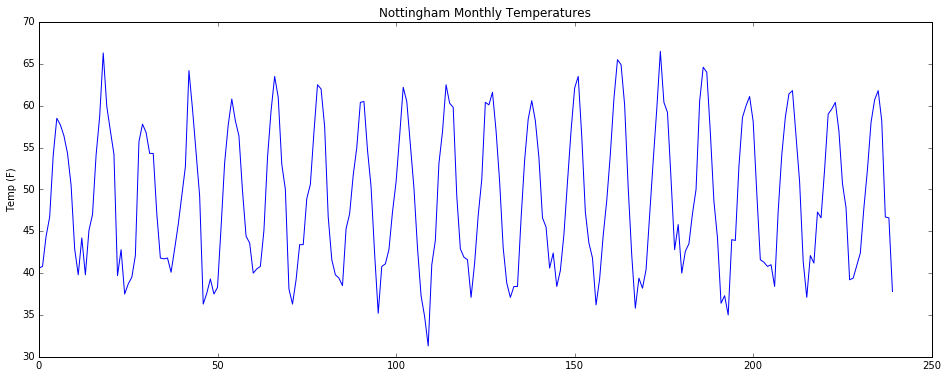

In [41]:
# Plot temperature over time

plt.figure(figsize = (16, 6))
plt.plot(df['Temperature'])
plt.title('Nottingham Monthly Temperatures')
plt.ylabel('Temp (F)')
plt.show()

In [5]:
# From the above plot of temperature over time the series looks to be stationary, with constant mean and variance.
# LSTM RNNs usual perform better on series that are stationary. If the series was found not to be stationary then
# differentiating the series may need to be considered.

In [6]:
# Forecasting using ARIMA model to compare with RNNs...

In [7]:
# Convert values to float

df = df.astype('float64')

In [8]:
# Scale data using MinMaxScaler so values are between 0 and 1

sc = MinMaxScaler()
scaled_df = sc.fit_transform(df)

In [9]:
# Create a sequence dataframe using data from the previous 6 months, which will be the input to the LSTM RNN.
# The target that we want to predict is time step t+1 using the features at time steps t-5 through to t.

y = [scaled_df[i + 6, 0] for i in range(len(scaled_df) - 6 - 1)]
X = [scaled_df[i:(i + 6), 0] for i in range(len(scaled_df) - 6 - 1)]
X_df = pd.DataFrame(X, columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])
X_df.head(2)

,X1,X2,X3,X4,X5,X6
0,0.264205,0.269886,0.372159,0.437500,0.647727,0.772727
1,0.269886,0.372159,0.437500,0.647727,0.772727,0.750000


In [10]:
# Create a train test split that respects order

X_train = np.array(X_df[0: int(len(X_df) * 0.7)])
X_test = np.array(X_df[int(len(X_df) * 0.7):])
y_train = np.array(y[0: int(len(X_df) * 0.7)])
y_test = np.array(y[int(len(X_df) * 0.7):])

In [11]:
# Reshape input to be of the form [samples, timesteps, features]

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1,  X_test.shape[1])

In [12]:
# Define Sequential model using Keras
model = Sequential()
# Add layer with four memory blocks, specifying the input dimension which is the number of features or values in the
# sequence. The activation function used by the gates in the block is tanh.
model.add(LSTM(4, input_dim = 6, activation = 'tanh'))
# Add dence layer with one unit, as we wish to forecast 1 time-period ahead
model.add(Dense(1))
# To evaluate the weights used by the gates in the network we must specify the loss function, and to optimise the 
# weights we must specify the optimiser. Because this is a regression problem, the loss function used will be 
# mean-squared error. The optimiser adam was chosen for no other reason than efficientsy. 
model.compile(loss = 'mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, nb_epoch = 100, batch_size = 1, verbose = 2)

Epoch 1/100
4s - loss: 0.1486
Epoch 2/100
1s - loss: 0.0799
Epoch 3/100
1s - loss: 0.0637
Epoch 4/100
1s - loss: 0.0520
Epoch 5/100
1s - loss: 0.0409
Epoch 6/100
1s - loss: 0.0306
Epoch 7/100
1s - loss: 0.0217
Epoch 8/100
1s - loss: 0.0150
Epoch 9/100
1s - loss: 0.0107
Epoch 10/100
1s - loss: 0.0085
Epoch 11/100
2s - loss: 0.0079
Epoch 12/100
1s - loss: 0.0075
Epoch 13/100
1s - loss: 0.0073
Epoch 14/100
2s - loss: 0.0071
Epoch 15/100
1s - loss: 0.0069
Epoch 16/100
1s - loss: 0.0070
Epoch 17/100
1s - loss: 0.0069
Epoch 18/100
1s - loss: 0.0069
Epoch 19/100
2s - loss: 0.0067
Epoch 20/100
2s - loss: 0.0067
Epoch 21/100
1s - loss: 0.0067
Epoch 22/100
2s - loss: 0.0066
Epoch 23/100
2s - loss: 0.0065
Epoch 24/100
2s - loss: 0.0067
Epoch 25/100
2s - loss: 0.0066
Epoch 26/100
2s - loss: 0.0064
Epoch 27/100
2s - loss: 0.0065
Epoch 28/100
2s - loss: 0.0065
Epoch 29/100
2s - loss: 0.0064
Epoch 30/100
2s - loss: 0.0064
Epoch 31/100
1s - loss: 0.0063
Epoch 32/100
1s - loss: 0.0063
Epoch 33/100
1s -

In [15]:
# Predict using trained network

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse tranform predictions using MinMaxScaler

train_predictions = sc.inverse_transform(train_predictions)
test_predictions = sc.inverse_transform(test_predictions)

In [29]:
# Shift train predictions for plotting

train_predictions_shift = np.empty_like(df)
train_predictions_shift[:, :] = np.nan
train_predictions_shift[6:len(train_predictions) + 6, :] = train_predictions

In [31]:
# Shift test predictions for plotting

test_predictions_shift = np.empty_like(df)
test_predictions_shift[:, :] = np.nan
test_predictions_shift[(len(train_predictions) + 6):(len(df)-1), :] = test_predictions

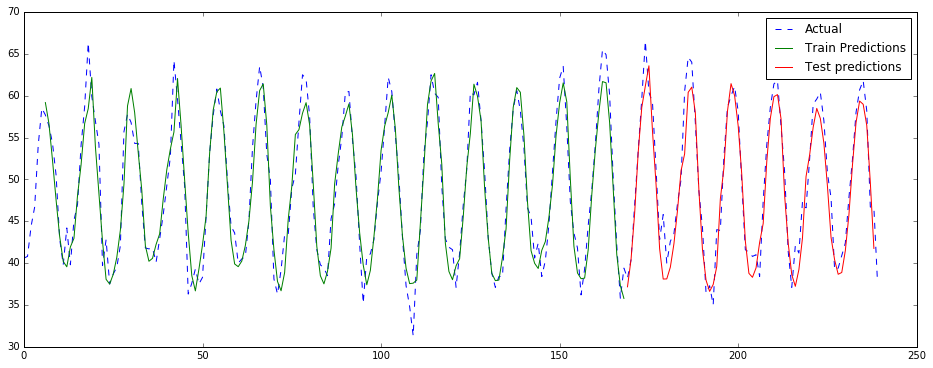

In [36]:
# Plot predictions

plt.figure(figsize = (16, 6))
plt.plot(df, color = 'blue', label = 'Actual', linestyle = '--')
plt.plot(train_predictions_shift, color = 'green', label = 'Train Predictions')
plt.plot(test_predictions_shift, color = 'red', label = 'Test predictions')
plt.legend()
plt.show()

In [40]:
# Mean squared error

print 'Training MSE: ', mean_squared_error(df[6:len(train_predictions) + 6], train_predictions)
print 'Test MSE: ', mean_squared_error(df[len(train_predictions) + 6: (len(df)-1) ], test_predictions)

Training MSE:  6.69074815168
Test MSE:  7.2331734101
